# This is How should a homework assignment look like!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
#
#
#Bild von Flugzeug und Vogel benötigt mehr als 1 minute 

In [2]:
'Funktion,die für ein Bild der Größe N * M den vektorisierten Laplace-Operator als dünn besetzte Matrix zurückgibt'
#check 
def Laplace(N, M):
    
    #Besetzung der Hauptdiagonalen von DN(2) und DM(2) mit Wert -2 und der Nebendiagonalen oberhalb und unterhalb der Hauptdiagonalen von DN(2) und DM(2) durch denr Wert 1
    D_N = np.eye(N) * (-2) +  np.eye(N, k=1)+np.eye(N, k= -1)
    D_M = np.eye(M) * (-2) + np.eye(M, k=1) +  np.eye(M, k= -1)

    #Bestimmen des vektorisieren Laplace-Operators als dünn besetzte Matrix gemäß den Anforderungen aus der Aufgabenstellung
    Laplace_operator = sc.sparse.kron(np.eye(M),D_N) + sc.sparse.kron(D_M, np.eye(N))

    return Laplace_operator


In [3]:
#Konstrukgiton des Gradienten 
def gradient(g):
#Gradient wird erstellt
    h,w = g.shape
    Dv_N = np.eye(h)*(-1) + np.eye(h,k=1)
    #Dv_N += np.eye(Höhe,k=1)

    Dv_M = np.eye(w)*(-1) +np.eye(w,k=1)
    #Dv_M += np.eye(Breite,k=1)

    #return np.dstack([Dv_N.dot(g),g.dot(Dv_M.T)])
    return np.dstack([Dv_N@g,g@Dv_M.T])


In [4]:
#es wird des rand des Bildes in Abhängigkeit von der eingestellen Koordinate bestimmt 
def rand_matrix(m,h,w,c):
    rand = []
    for i in range(h):
        if(i == 0 or i == h-1 ):
            for j in range(w-1):
               
                rand.append(m[i+c[0]][j+c[1]])
                #rand.append(i+j*height)
        else:
            
            rand.append(m[i+c[0]][c[1]])# erster pixel
            rand.append(m[i+c[0]][w+c[1]-1])#letzter pixel
            
                
    return rand 


In [5]:
#lösen des Gleichungssystems. 
#f = k
#f großes bild, g kleines bild 
def poisson_solution(g,f,coordinate,Lap,Rand):
    Höhe,Breite = g.shape
    ho,w = g.shape

    # b = Laplace*vec(g)
    b = Lap@g.flatten(order='F')

    
    #rand des großen bildes wird ermittelt 
    Rand_f = rand_matrix(f,ho,w,coordinate)#Rand_des_Bildes(f,Höhe,Breite,coordinate)
#Wir ersetzen die entsprechenden Zeilen in b den entsprechenden Randwerten von Hintergrundbild f (diese Zeilen liegen nun den Einheitsmatrix-Zeilen gegenüber)
    for z in range(len(Rand_f)):
        b[Rand[z]] = Rand_f[z]
        
#Wir multiplizieren beide Seiten des LGS mit der Transponierten von Lap, um die linke Seite des LGS symmetrisch und pos. definit zu machen
#lösen
    h = sc.sparse.linalg.cgs(Lap,b)[0]
    h = np.round(h).astype(int)# ersetzen durch h = h/255 
    h = 1.0*h/255
    h = h.reshape((w,ho))
    return h.T


In [6]:
#Hilffunktion um die Einträge des Randes durch 
def transform(l,r,d):
    for i in r:
        l.data[l.indptr[i]:l.indptr[i+1]] = 0 
    l=l.tolil()
    for i in r:
        l[i,i] = 1.0 
        
    
    #verbessern !!!
    #for i in r:
    #    liste = np.zeros(d)
    #    liste[i] = 1
    #    l[i,:] = liste

    return l.tocsr()




In [7]:
#funktion 2 aufgabe 
#seamless_poisson('link.jpg','link2.jpg',"(0,0)")
def funktion2(g,f,c):
    
    #Auslesen der Bilddateien, g ist einzufügendes Bild, f ist Bild, in welches eingefügt wird
    img = 1.0*plt.imread(str(g)).copy()
    
    img2 =1.0*plt.imread(str(f)).copy()
    
    
    h, w, _ = img.shape

    Rand = erstelle_rand(h,w)    
    Lap = transform(Laplace(h,w),Rand,h*w )


    #referenzierung der Poisson_lösung
    
    c0 = poisson_solution(img[:,:,0],img2[:,:,0],c,Lap,Rand)
    

    c1 = poisson_solution(img[:,:,1],img2[:,:,1],c,Lap,Rand)
    

    c2 = poisson_solution(img[:,:,2],img2[:,:,2],c,Lap,Rand)
    
    
    #Zusammenfügen der Lösungsbilder
    x = np.dstack((c0,c1,c2))
    
    #einsetzen das Bild in das Bild 
    img2 = img2/255
    img2[c[0]:c[0]+h,c[1]:c[1]+w] = x 
    #insert_picture(Höhe,Breite,coordinate,img2,x)
    #return img2 
    
    
    plt.imshow(img2)
    plt.show()

In [8]:

def vektorfeld_init(g,f):

    #hier wird ein Vektorfeld erzeugt und bits für bits vergliechen um ins bild einzufügen
    #h,w = g.shape
    
    h,w = g.shape
    grad_g = gradient(g) 
    grad_f = gradient(f)
    v = []
    for i in range(h):
        for j in range(w):
            gij = grad_g[i][j]
            fij = grad_f[i][j]
            #es wird bit für bit die Steigung verglichen und hinzugefügt
            if np.linalg.norm(fij)>np.linalg.norm(gij):
                v.append(fij)
            else:
                v.append(gij)
    return v_creator(v,h,w)
    

In [9]:
#hilfsfunktion für das Kontruieren des Vektorfeldes 
def v_creator(v,h,w):
    
    #v0 = np.array([i[0] for i in v])
    v0 = np.array([i[0] for i in v]).reshape(h,w)
    
    #v1 = np.array([i[1] for i in v])
    v1 = np.array([i[1] for i in v]).reshape(h,w)
    #v0 = v0.reshape(h,w)
    #v1 = v1.reshape(h,w)

    D_rN = np.eye(h)+(-1)*np.eye(h,k=-1)
    D_rM = np.eye(w)+(-1)*np.eye(w,k=-1)
    
    
    return D_rN@v0+v1@D_rM.T

    #return D_rN.dot(v0) + v1.dot(D_rM.T)


In [10]:

#aufgabe 3 
#Gradienten_solution 
def gradient_solution(g,f,coordinate,Lap,Rand):
    

    b = vektorfeld_init(g,f).flatten(order= 'F')
    ho,w = g.shape
    #Rand_f = Rand_des_Bildes_klein(f,Höhe,Breite,coordinate)#vektor
    #lösen des Rands des kleinen Bildes 
    Rand_f = rand_matrix(f,ho,w,(0,0))#Rand_des_Bildes(f,Höhe,Breite,(0,0))
    
    
    for i in range(len(Rand_f)):# bedingung 2 : rand(h) = rand(f) 
        b[Rand[i]] = Rand_f[i]
        #rand(h) = rand(f) 
    
    #lösen des Gleichungsystems 
    h = sc.sparse.linalg.cgs(Lap,b,atol=1e-7)[0]
    h = h/255
    h = h.reshape((w,ho))
    h = h.T

    return h

In [11]:

#es werden die Koordinaten des Randes Konstruiert. 
def erstelle_rand(height,withd):
    rand = []
    for i in range(height):

        if(i == 0 or i == height-1 ):
            for j in range(withd):
                rand.append(i+j*height)
        else:    
            rand.append(i+(height-1)*withd)
            rand.append(i)
        
    return rand 

In [12]:
   
#Aufgabe 3 
#seamples_gemischt(g.jpg,f.jpg,())
#f großes bild , g kleiens bild 
def funktion3(g,f,c):
    
    img = 1.0*plt.imread(str(g)).copy()
    img2 =1.0*plt.imread(str(f)).copy()
    
    h, b, _ = img.shape
  
    Rand = erstelle_rand(h,b)
    
    
    Lap = transform(Laplace(h,b),Rand,h*b )


    x0 = img2[c[0]:c[0]+h,c[1]:c[1]+b,0]
    x1 = img2[c[0]:c[0]+h,c[1]:c[1]+b,1]
    x2 = img2[c[0]:c[0]+h,c[1]:c[1]+b,2]
   
    
    c0 = gradient_solution(img[:,:,0],x0,c,Lap,Rand)
    c1 = gradient_solution(img[:,:,1],x1,c,Lap,Rand)
    c2 = gradient_solution(img[:,:,2],x2,c,Lap,Rand)
    
    
    #Zusammenfügen der RGB Matrizen 
    x = np.dstack((c0,c1,c2))
    #einsetzen das Bild in das Bild 
    img2 = img2/255
    img2[c[0]:c[0]+h,c[1]:c[1]+b] = x 
    
    plt.imshow(img2)
    plt.show()


In [13]:
#zeige die erste Funktion an 
def funktion1(n,m):
    a = Laplace(n,m).toarray()
    plt.imshow(a)

In [48]:
#es wird das Bild hinzugefügt ohne es zu bearbeitet zu haben 
#f gfroßes bild, g kleiens bild 
def insert(f,g,c):
    img = plt.imread(str(g)).copy()
    img2 =plt.imread(str(f)).copy()
    h,b,d = img.shape
    x = np.dstack((img[:,:,0],img[:,:,1],img[:,:,2]))
    img2[c[0]:c[0]+h,c[1]:c[1]+b,:] = img[:,:,:] 
    plt.imshow(img2)


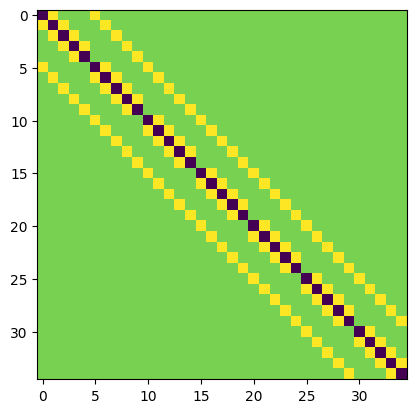

In [33]:
funktion1(5,7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


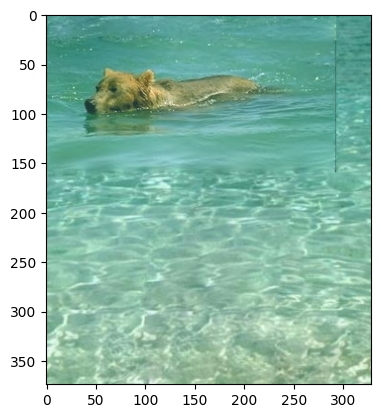

In [15]:
funktion2("bear.jpg",'water.jpg',(0,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


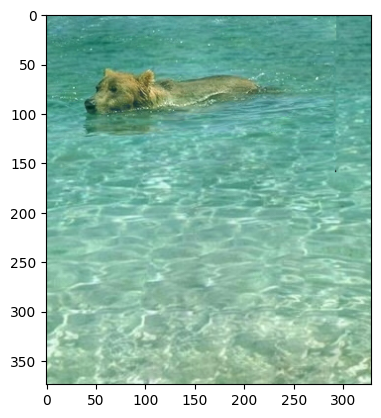

In [16]:
funktion3("bear.jpg",'water.jpg',(0,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


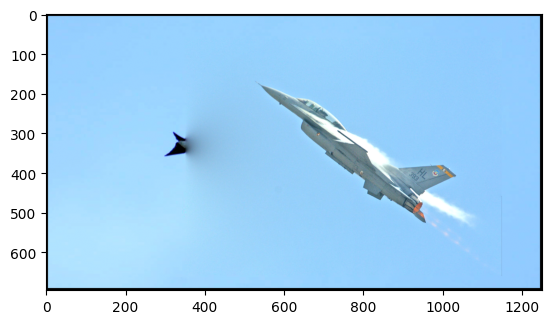

In [15]:
funktion2("plane.jpg",'bird.jpg',(60,350))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


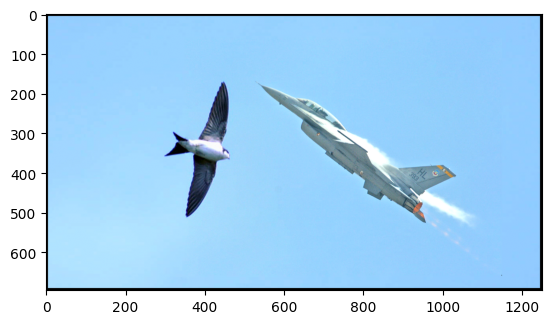

In [19]:
#die generierung des Bildes benötig +1 minuten 
funktion3("plane.jpg",'bird.jpg',(60,350))

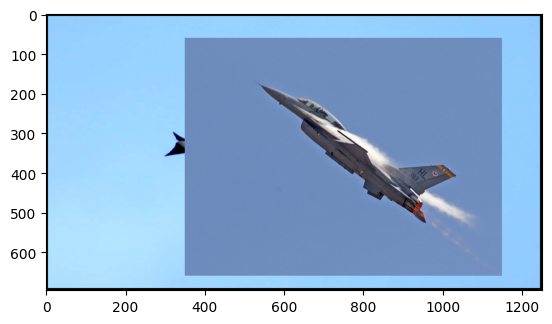

In [47]:
#unbearbeitet hinzufügen des bildes fogel und flugzeug 
insert("bird.jpg",'plane.jpg',(60,350))

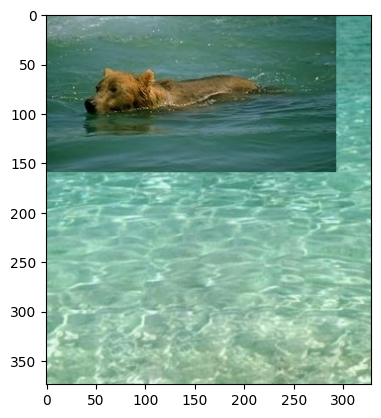

In [49]:
#unbearbeitet hinzufügen des bildes fogel und flugzeug 
insert("water.jpg",'bear.jpg',(0,0))